In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.losses import BendingEnergyLoss
import numpy as np
import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/2Dfat_3333.zip;

In [ ]:
device = torch.device("cuda:0")
convert_tensor = transforms.ToTensor()

p = 31 #how many images from each dataset to use to train + 1 (max 101)
q = 33 #number of datasts to use (max 33)
fn =[ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,q):
  for v in range(0,p):
    n = i+1
    image = Image.open(f'/content/train_{n}/00{v}_rt.png')
    image = convert_tensor(image)
    image1 = image.unsqueeze(0)
    image1 = image1.to(device)
    fn[i].append(image1)

In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones, rotations are clockwise in degrees
rotations = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
translations_x = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
translations_y = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, q):
  rotations[i].append(0)
  #translations_x[i].append(0)
  #translations_y[i].append(0)
  for v in range(1, p):
    n = i + 1
    with open(f"/content/train_{n}/00{v}_augments.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        r1 = (r1*np.pi)/180
        rotations[i].append(r1)
        line1 = lines[1]
        t1 = float(line1.split("=")[1])
        translations_y[i].append(-t1)
        line2 = lines[2]
        t2 = float(line2.split("=")[1])
        #-ve sign?
        translations_x[i].append(t2)

In [ ]:
ddfs = [ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, q):
  for (tx, ty, r) in zip(translations_x[i], translations_y[i], rotations[i]):
    image_width = 128
    image_height = 128

    # Create mesh grid
    x, y = np.meshgrid(range(image_height), range(image_width), indexing='ij')

    # Initialize tensor
    displacement_field = np.zeros((image_height, image_width, 2))

    # Apply transformation parameters - affine transformation matrix: [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
    homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), np.ones_like(x.flatten())])
    transformation_matrix = np.array([[np.cos(r), np.sin(r), tx], [-np.sin(r), np.cos(r), ty]])
    transformed_homogeneous_coordinates = transformation_matrix @ homogeneous_coordinates

    # Compute displacement field
    displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width)) - x
    displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width)) - y

    displacementfield0 = torch.tensor(displacement_field)
    displacementfield = displacementfield0.unsqueeze(0)
    displacementfield = displacementfield.permute(0, 3, 1, 2)
    displacementfield = displacementfield.to(device)
    ddfs[i].append(displacementfield)

#print(ddfs[1])
  

In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (128, 128),
    "spatial_dims": 2,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param).to(device)
net.output_block.fc.register_forward_hook(get_activation("fc"))
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)

Train

In [ ]:
max_epochs = 60
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for i in range(0, 33):
      for (moving1, displacementfield) in zip(fn[i], ddfs[i]):
          step += 1
          optimizer.zero_grad()
          result = net(torch.cat((fn[i][0], moving1), dim=1))
          loss = custom_loss(result, displacementfield) + 100 * regularization(result) #was 10 previously
          #loss = custom_loss1(result, displacementfield)
          #loss = customloss2(result, transmat)

          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/60
epoch 1 average loss: 47.3184
----------
epoch 2/60
epoch 2 average loss: 77.3182
----------
epoch 3/60
epoch 3 average loss: 47.9579
----------
epoch 4/60
epoch 4 average loss: 31.2437
----------
epoch 5/60
epoch 5 average loss: 46.0888
----------
epoch 6/60
epoch 6 average loss: 44.4469
----------
epoch 7/60
epoch 7 average loss: 8.8131
----------
epoch 8/60
epoch 8 average loss: 7.3602
----------
epoch 9/60
epoch 9 average loss: 6.4979
----------
epoch 10/60
epoch 10 average loss: 11.4971
----------
epoch 11/60
epoch 11 average loss: 25.0571
----------
epoch 12/60
epoch 12 average loss: 20.0909
----------
epoch 13/60
epoch 13 average loss: 11.0679
----------
epoch 14/60
epoch 14 average loss: 9.6902
----------
epoch 15/60
epoch 15 average loss: 15.3298
----------
epoch 16/60
epoch 16 average loss: 34.0333
----------
epoch 17/60
epoch 17 average loss: 24.2561
----------
epoch 18/60
epoch 18 average loss: 8.5321
----------
epoch 19/60
epoch 19 average loss: 3.954

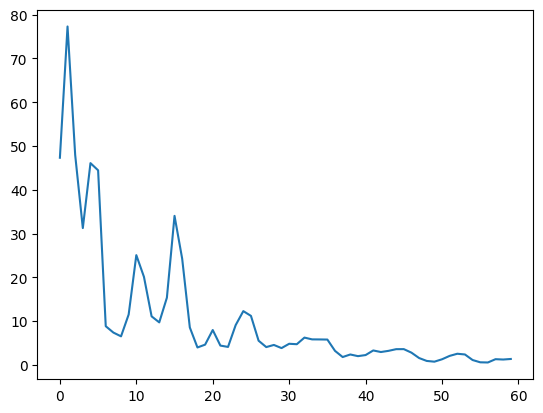

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with validation data

In [ ]:
fn1 =[ [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,33):
  n = i+1
  fixed3 = Image.open(f'/content/train_{n}/000_rt.png')
  fixed3 = convert_tensor(fixed3)
  fixed4 = fixed3.unsqueeze(0)
  fixed4 = fixed4.to(device)
  fn[i].append(fixed4)
  for v in range(98, 101):
    image = Image.open(f'/content/train_{n}/00{v}_rt.png')
    image = convert_tensor(image)
    image1 = image.unsqueeze(0)
    image1 = image1.to(device)
    fn1[i].append(image1)

In [ ]:
import timeit
start = timeit.default_timer()
activations = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0,33):
  fixed2 = fn1[i][0]
  for m in range(1,4):
    image1 = fn[i][m]
    ddf = net(torch.cat((image1, fixed2), dim=1))
    activations[i].append(activation['fc'])

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.25868763099992975


In [ ]:
predx = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
predy = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
predr = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

for i in range(0,33):
  for activation in activations[i]:
    a = activation[0,2].item()
    predx[i].append(a)

    b = activation[0,5].item()
    predy[i].append(b)

    c = activation[0, 0].item()
    d = activation[0, 1].item()
    e = activation[0, 3].item()
    f = activation[0, 4].item()

    g = (np.arcsin(d) + np.arcsin(-e))/2
    predr[i].append(g)

In [ ]:
#translations parameters for test data
#y:
test_x = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
test_y = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
test_r = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(0, 33):
  for v in range(98, 101):
    n = i + 1
    with open(f"/content/train_{n}/00{v}_augments.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        r1 = (r1*np.pi)/180
        test_r[i].append(r1)
        line1 = lines[2]
        t1 = float(line1.split("=")[1])
        test_x[i].append(t1)
        line2 = lines[1]
        t2 = float(line2.split("=")[1])
        test_y[i].append(-t2)

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_x[i], predx[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.legend(['y translations'],fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')

'%matplotlib inline\nfor i in range (0, 33):\n  plt.scatter(test_x[i], predx[i], color=\'red\')\n# set the x and y axis labels\nplt.xlabel("Ground Truths", fontsize = 15)\nplt.ylabel("Registration Parameters", fontsize = 15)\nplt.xlim([-5, 5])\nplt.ylim([-5, 5])\nplt.legend([\'y translations\'],fontsize=15, loc=\'upper left\')\n\nplt.plot([-5, 5], [-5, 5], linestyle=\'--\', color=\'gray\')'

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_y[i], predy[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.legend(['x translations'],fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')

'%matplotlib inline\nfor i in range (0, 33):\n  plt.scatter(test_y[i], predy[i], color=\'red\')\n# set the x and y axis labels\nplt.xlabel("Ground Truths", fontsize = 15)\nplt.ylabel("Registration Parameters", fontsize = 15)\nplt.xlim([-5, 5])\nplt.ylim([-5, 5])\n\nplt.legend([\'x translations\'],fontsize=15, loc=\'upper left\')\n\nplt.plot([-5, 5], [-5, 5], linestyle=\'--\', color=\'gray\')'

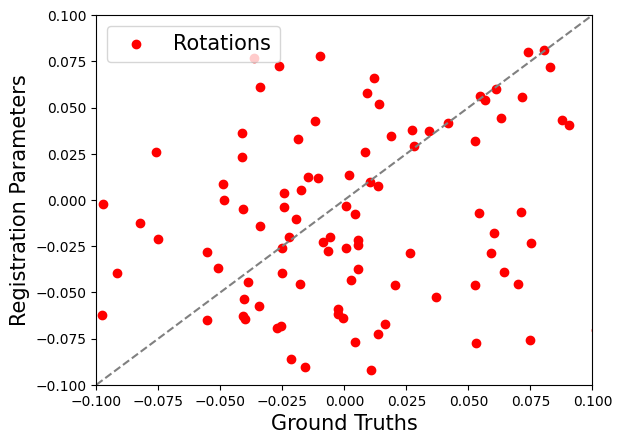

In [ ]:
%matplotlib inline
for i in range (0, 33):
  plt.scatter(test_r[i], predr[i], color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

plt.legend(['Rotations'],fontsize=15, loc='upper left')

plt.plot([-0.1, 0.1], [-0.1, 0.1], linestyle='--', color='gray')

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/2D_fatrots_60.pth')

In [ ]:
from scipy import stats
differences = []
for i in range (0, 33):
  for (r, rr, x, xr, y, yr) in zip(test_r[i], predr[i], test_x[i], predx[i], test_y[i], predy[i]):
      # normalise each absolute difference to the ground truth parameter for that variable
      differences.append([np.abs((r - rr) / r), np.abs((x - xr) / x), np.abs((y - yr) / y)])

# separating the data out into lists for each difference in parameter - way to do this earlier on in the code?
n_map = ['rotation abs difference norm', 'y translation abs difference norm', 'x translation abs difference norm']
for n in range(3):
    data_xr = []
    for i, difference in enumerate(differences):
        data_xr.append(difference[n])
    # for labelling
    n = n_map[n]
    # analysis - rounding to 2 dp
    mean = np.mean(data_xr)
    mean = np.round(mean, 2)
    median = np.median(data_xr)
    median = np.round(median, 2)
    mode = stats.mode(data_xr)
    mode = mode.mode[0]
    mode = round(mode, 2)
    stddev = np.std(data_xr)
    stddev = np.round(stddev, 2)
    variance = np.var(data_xr)
    variance = np.round(variance, 2)

    print(f"{n} Mean: {mean}\n")
    print(f"{n} Median : {median}\n")
    print(f"{n} Mode: {mode}\n")
    print(f"{n} SD: {stddev}\n")
    print(f"{n} Var: {variance}\n")

'from scipy import stats\ndifferences = []\nfor i in range (0, 33):\n  for (r, rr, x, xr, y, yr) in zip(test_r[i], predr[i], test_x[i], predx[i], test_y[i], predy[i]):\n      # normalise each absolute difference to the ground truth parameter for that variable\n      differences.append([np.abs((r - rr) / r), np.abs((x - xr) / x), np.abs((y - yr) / y)])\n\n# separating the data out into lists for each difference in parameter - way to do this earlier on in the code?\nn_map = [\'rotation abs difference norm\', \'y translation abs difference norm\', \'x translation abs difference norm\']\nfor n in range(3):\n    data_xr = []\n    for i, difference in enumerate(differences):\n        data_xr.append(difference[n])\n    # for labelling\n    n = n_map[n]\n    # analysis - rounding to 2 dp\n    mean = np.mean(data_xr)\n    mean = np.round(mean, 2)\n    median = np.median(data_xr)\n    median = np.round(median, 2)\n    mode = stats.mode(data_xr)\n    mode = mode.mode[0]\n    mode = round(mode, 2)